**This Notebook goes along with convnet_devp2.py. It records the experimental convnet tuning process using a small batch of fixed data and using AdamOptimizer and linearly stacked model. Compared to experiment1 notebook, it also experimented with Xavier initialization**

In [1]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from convnet_devp2 import *

/Users/Zhongyu/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Zhongyu/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Load Data

In [44]:
train_dataset, train_labels, test_dataset, test_labels = load_data()

Loading the training data...
Loading the testing data...


### Split Training and Validation Data

In [45]:
train_dataset, valid_dataset, train_labels, valid_labels = \
    train_test_split(train_dataset, train_labels, test_size=10000,\
    random_state=897, stratify=train_labels)

### Reshape Data - 32x32x3

In [46]:
train_dataset = np.rollaxis(train_dataset.reshape((-1,3,32,32)), 1, 4)
valid_dataset = np.rollaxis(valid_dataset.reshape((-1,3,32,32)), 1, 4)
test_dataset = np.rollaxis(test_dataset.reshape((-1,3,32,32)), 1, 4)
print 'Dataset\t\tFeatureShape\t\tLabelShape'
print 'Training set:\t', train_dataset.shape,'\t', train_labels.shape
print 'Validation set:\t', valid_dataset.shape, '\t', valid_labels.shape
print 'Testing set:\t', test_dataset.shape, '\t', test_labels.shape

Dataset		FeatureShape		LabelShape
Training set:	(40000, 32, 32, 3) 	(40000,)
Validation set:	(10000, 32, 32, 3) 	(10000,)
Testing set:	(10000, 32, 32, 3) 	(10000,)


### Data Augmentation - 50% of training upside down flip; 50% mirror flip

In [47]:
train_dataset, train_labels = augment_data(train_dataset, train_labels)
print 'Dataset\t\tFeatureShape\t\tLabelShape'
print 'Training set:\t', train_dataset.shape,'\t', train_labels.shape
print 'Validation set:\t', valid_dataset.shape, '\t', valid_labels.shape
print 'Testing set:\t', test_dataset.shape, '\t', test_labels.shape

Dataset		FeatureShape		LabelShape
Training set:	(80000, 32, 32, 3) 	(80000,)
Validation set:	(10000, 32, 32, 3) 	(10000,)
Testing set:	(10000, 32, 32, 3) 	(10000,)


### Data Preprocess - center data; reduce precision

In [48]:
# Dataset Parameters
image_size = 32
num_labels = 10
num_channels = 3
train_dataset, train_labels = preprocess_data(train_dataset, train_labels, num_labels)
valid_dataset, valid_labels = preprocess_data(valid_dataset, valid_labels, num_labels)
test_dataset,  test_labels  = preprocess_data(test_dataset,  test_labels,  num_labels)

In [49]:
print 'Dataset\t\tFeatureShape\t\tLabelShape'
print 'Training set:\t', train_dataset.shape,'\t', train_labels.shape
print 'Validation set:\t', valid_dataset.shape, '\t', valid_labels.shape
print 'Testing set:\t', test_dataset.shape, '\t', test_labels.shape

Dataset		FeatureShape		LabelShape
Training set:	(80000, 32, 32, 3) 	(80000, 10)
Validation set:	(10000, 32, 32, 3) 	(10000, 10)
Testing set:	(10000, 32, 32, 3) 	(10000, 10)


### Factorize ConvNet Computation

In [164]:
def initialize_variables(convnet_shapes, initializer=tf.truncated_normal_initializer(stddev=.01)):
    for item in convnet_shapes:
        scope_name, shape = item[0], item[1]
        with tf.variable_scope(scope_name) as scope:
            w = tf.get_variable("wt", shape, initializer = initializer)
            b = tf.get_variable("bi", shape[-1], initializer = tf.constant_initializer(1.0))
            scope.reuse_variables()

In [165]:
def train_convnet(graph, model, tf_data, convnet_shapes, hyperparams, steps, minibatch=False, *args):
    # Default exponential decay learning rate and AdamOptimizer
    print "Prepare network parameters", "."*32
    with graph.as_default():
        # Setup training, validation, testing dataset
        tf_train_dataset, tf_train_labels = tf_data['train_X'], tf_data['train_y']
        tf_valid_dataset, tf_valid_labels = tf_data['valid_X'], tf_data['valid_y']
        tf_test_dataset , tf_test_labels  = tf_data['test_X'] , tf_data['test_y']
        # Initialize Weights and Biases
        scopes = zip(*convnet_shapes)[0]
        initialize_variables(convnet_shapes, initializer=hyperparams['initializer'])
        
        # Unwrap HyperParameters
        keep_prob, tfoptimizer = hyperparams['keep_prob'], hyperparams['optimizer']
        init_lr, global_step = hyperparams['init_lr'], tf.Variable(0)
        decay_steps, decay_rate = hyperparams['decay_steps'], hyperparams['decay_rate']
        learning_rate = tf.train.exponential_decay(init_lr, global_step, decay_steps, decay_rate, staircase=True)
        
        # Compute Loss Function
        train_logits = model(tf_train_dataset, scopes, True, keep_prob)
        train_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_logits, tf_train_labels))
        train_prediction = tf.nn.softmax(train_logits)
        # Optimizer
        optimizer = tfoptimizer(learning_rate).minimize(train_loss, global_step=global_step)
        
        # Prediction on Validation and Test set
        valid_logits = model(tf_valid_dataset, scopes, False)
        valid_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(valid_logits, tf_valid_labels))
        valid_prediction = tf.nn.softmax(valid_logits)
        if tf_test_dataset!=None:
            test_prediction = tf.nn.softmax(model(tf_test_dataset, scopes, False))
        else:
            test_prediction = None
    
    # Train Convnet
    num_steps = steps
    train_losses, valid_losses = np.zeros(num_steps), np.zeros(num_steps)
    train_acc, valid_acc = np.zeros(num_steps), np.zeros(num_steps)
    
    print "Start training", '.'*32
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print('Initialized')
        for step in range(num_steps):
            # Handle MiniBatch
            if minibatch:
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                batch_data = train_dataset[offset:(offset+batch_size), :, :, :]
                batch_labels = train_labels[offset:(offset+batch_size), :]
                feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels}
            else:
                feed_dict = {}
            # Run session...
            _, tl, predictions = session.run([optimizer, train_loss, train_prediction], feed_dict=feed_dict)
            train_losses[step] = tl
            if minibatch:
                train_acc[step] = accuracy(predictions, batch_labels)
            else:
                train_acc[step] = accuracy(predictions, tf_train_labels.eval())
            # Compute validation set accuracy batch by batch
            valid_losses[step] = valid_loss.eval()
            valid_acc[step] = accuracy(valid_prediction.eval(), tf_valid_labels.eval())
            if ((step % 10 == 0)):
                print('Epoch: %d:\tLoss: %f\tTrain Acc: %.2f%%\tValid Acc: %2.f%%\tLearning rate: %.6f' \
                      %(step, tl, (train_acc[step]*100), (valid_acc[step]*100), learning_rate.eval(), ))
        print "Finished training", '.'*32
        # Compute test set accuracy
        if test_prediction!=None:
            test_acc = accuracy(test_prediction.eval(), tf_test_labels.eval())
            print("Test accuracy: %2.f%%" %(test_acc*100))
        else:
            test_acc = None
    # Group training data into a dictionary
    training_data = {'train_losses' : train_losses, 'train_acc' : train_acc, \
                     'valid_losses' : valid_losses, 'valid_acc' : valid_acc, 'test_acc' : test_acc}
    return graph, training_data

### Generate a fixed small batch of data 

In [60]:
train_batch_size = 32
valid_batch_size = 32
train_batch, train_label_batch = generate_batch(train_dataset, train_labels, train_batch_size)
valid_batch, valid_label_batch = generate_batch(valid_dataset, valid_labels, valid_batch_size)

### Setup Network Parameters

In [233]:
# Parameters for building blocks
batch_size = 20
kernel_size3 = 3
kernel_size5 = 5
num_filter = 64
fc_size1 = 512

In [98]:
# Setup shapes for each layer in the convnet
convnet_shapes = [['conv1', [kernel_size5, kernel_size5, num_channels, num_filter]],
                  ['conv2', [kernel_size3, kernel_size3, num_filter, num_filter]],
                  ['conv3', [kernel_size5, kernel_size5, num_filter, num_filter]],
                  ['fc1'  , [(image_size/2/2/2)**2*num_filter, fc_size1]],
                  ['fc2'  , [fc_size1, num_labels]]]

In [192]:
graph = tf.Graph()
with graph.as_default():
    tf_data = {'train_X': tf.constant(train_batch), 'train_y': tf.constant(train_label_batch),
               'valid_X': tf.constant(valid_batch), 'valid_y': tf.constant(valid_label_batch),
               'test_X' : None, 'test_y': None}

In [193]:
hyperparams={'keep_prob': 1., 'init_lr': 0.00001, 'decay_rate': .7, 
             'initializer':tf.truncated_normal_initializer(stddev=.01),
             'decay_steps':1000, 'optimizer':tf.train.AdamOptimizer}

In [194]:
model = convnet_stack
epoch = 501

In [195]:
graph, training_data = train_convnet(graph, model, tf_data, convnet_shapes, hyperparams, epoch, False)

Prepare network parameters ................................
Start training ................................
Initialized
Epoch: 0:	Loss: 2.311404	Train Acc: 9.38%	Valid Acc:  9%	Learning rate: 0.000010
Epoch: 10:	Loss: 2.273181	Train Acc: 9.38%	Valid Acc: 12%	Learning rate: 0.000010
Epoch: 20:	Loss: 2.237401	Train Acc: 21.88%	Valid Acc:  6%	Learning rate: 0.000010
Epoch: 30:	Loss: 2.203343	Train Acc: 21.88%	Valid Acc:  6%	Learning rate: 0.000010
Epoch: 40:	Loss: 2.170551	Train Acc: 21.88%	Valid Acc:  6%	Learning rate: 0.000010
Epoch: 50:	Loss: 2.139519	Train Acc: 21.88%	Valid Acc:  6%	Learning rate: 0.000010
Epoch: 60:	Loss: 2.111375	Train Acc: 21.88%	Valid Acc:  6%	Learning rate: 0.000010
Epoch: 70:	Loss: 2.087911	Train Acc: 21.88%	Valid Acc:  6%	Learning rate: 0.000010
Epoch: 80:	Loss: 2.069323	Train Acc: 21.88%	Valid Acc:  6%	Learning rate: 0.000010
Epoch: 90:	Loss: 2.058827	Train Acc: 21.88%	Valid Acc:  6%	Learning rate: 0.000010
Epoch: 100:	Loss: 2.050394	Train Acc: 21.88%	Valid Ac

***
### Implement functions for random search - Log Space Search 

In [234]:
def generate_hyperparams():
    # Generate random hyperparameters Log Space
    keep_prob = np.random.uniform(0.0, 1.0)
    init_lr = 10**np.random.uniform(-5, -2)
    #decay_rate = np.random.uniform(.8, 1.)
    init_std = 10**np.random.uniform(-3, -1)
    hyperparams={'keep_prob': keep_prob, 'init_lr': init_lr, 'decay_rate': 1., 'decay_steps':1000,
                 'init_std': init_std}
    return hyperparams

In [262]:
def random_search(num_experiments, train_batch_size, valid_batch_size, convnet_shapes, epoch):
    experiment_data = {}
    for i in range(num_experiments):
        # Prepare small batch of data for experimental training
        train_batch, train_label_batch = generate_batch(train_dataset, train_labels, train_batch_size)
        valid_batch, valid_label_batch = generate_batch(valid_dataset, valid_labels, valid_batch_size)
        # Sample random HyperParameters
        hyperparams = generate_hyperparams()
        # Prepare data for tensorflow
        graph = tf.Graph()
        with graph.as_default():
            tf_data = {'train_X': tf.constant(train_batch), 'train_y': tf.constant(train_label_batch),
                       'valid_X': tf.constant(valid_batch), 'valid_y': tf.constant(valid_label_batch),
                       'test_X' : None, 'test_y': None}
            tfoptimizer = tf.train.GradientDescentOptimizer
            #tfoptimizer = tf.train.AdamOptimizer
        hyperparams['optimizer'] = tfoptimizer
        hyperparams['initializer'] = tf.truncated_normal_initializer(stddev=hyperparams['init_std'])
        # Train convnet
        model = convnet_stack
        _, training_data = train_convnet(graph, model, tf_data, convnet_shapes, hyperparams, epoch, False)
        key = (hyperparams['keep_prob'], hyperparams['init_lr'], hyperparams['init_std'])
               #hyperparams['decay_rate'],hyperparams['decay_steps'] )
        experiment_data[key] = training_data
        print "Finished experiment ", str(i)
        print "="*100
    return experiment_data

### Random Search Through Hyperparameter Space

In [236]:
num_exp = 5
train_batch_size = 64
valid_batch_size = 32
epoch = 201

In [237]:
experiment_data = random_search(num_exp, train_batch_size, valid_batch_size, convnet_shapes, epoch)

Prepare network parameters ................................
Start training ................................
Initialized
Epoch: 0:	Loss: 17.364307	Train Acc: 6.25%	Valid Acc: 25%	Learning rate: 0.000052
Epoch: 10:	Loss: 10.078226	Train Acc: 17.19%	Valid Acc: 16%	Learning rate: 0.000052
Epoch: 20:	Loss: 8.801737	Train Acc: 6.25%	Valid Acc: 16%	Learning rate: 0.000052
Epoch: 30:	Loss: 5.732804	Train Acc: 6.25%	Valid Acc: 22%	Learning rate: 0.000052
Epoch: 40:	Loss: 3.347739	Train Acc: 7.81%	Valid Acc: 25%	Learning rate: 0.000052
Epoch: 50:	Loss: 3.056859	Train Acc: 17.19%	Valid Acc: 25%	Learning rate: 0.000052
Epoch: 60:	Loss: 2.691679	Train Acc: 12.50%	Valid Acc: 25%	Learning rate: 0.000052
Epoch: 70:	Loss: 2.782831	Train Acc: 10.94%	Valid Acc: 25%	Learning rate: 0.000052
Epoch: 80:	Loss: 2.393873	Train Acc: 10.94%	Valid Acc: 25%	Learning rate: 0.000052
Epoch: 90:	Loss: 2.614728	Train Acc: 4.69%	Valid Acc: 25%	Learning rate: 0.000052
Epoch: 100:	Loss: 2.538908	Train Acc: 6.25%	Valid Acc:

### Analyze Experiment Data

In [2]:
def plot_data(data):
    epoch = range(data['train_losses'].shape[0])
    plt.subplot(211)
    plt.plot(epoch, data['train_losses'], label= 'training loss')
    plt.plot(epoch, data['valid_losses'], label='validation loss')
    plt.ylim([-.1,4])
    plt.legend(loc='upper right')
    plt.subplot(212)
    plt.plot(epoch, data['train_acc'], label='training accuracy')
    plt.plot(epoch, data['valid_acc'], label='validation accuracy')
    plt.ylim([0.0, 1.1])
    plt.legend(loc='lower right')
    plt.show()

keep_prob		learning rate		init_std		valid accuracy
0.649293680231 		6.12329376632e-05 	0.00886860991705 	0.25


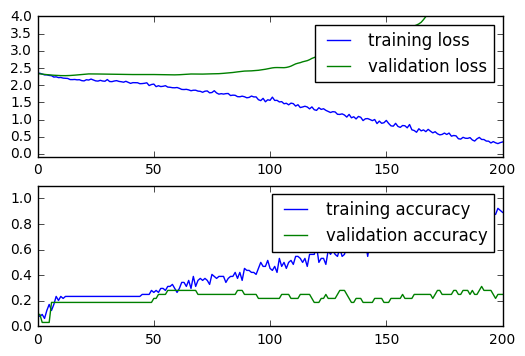

keep_prob		learning rate		init_std		valid accuracy
0.190394106196 		0.000286648956852 	0.0134451033267 	0.34375


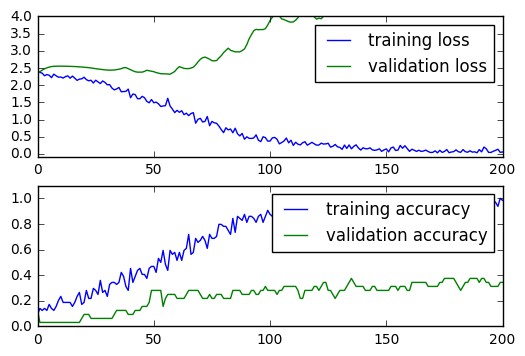

In [239]:
for key in experiment_data.keys():
    exp_data = experiment_data[key]
    if (exp_data['valid_acc'][-1]>.2) and (exp_data['train_acc'][-1]>.85):
        print "="*110
        print 'keep_prob\t\t', 'learning rate\t\t', 'init_std\t\t', 'valid accuracy'
        print key[0],'\t\t',key[1],'\t',key[2],'\t',exp_data['valid_acc'][-1]
        plot_data(exp_data)

***
### Fine Tune through - non-log space

In [263]:
def generate_hyperparams():
    # Generate random hyperparameters - Regular Space
    keep_prob = np.random.uniform(0.0, 0.6)
    init_lr = np.random.uniform(0.0001, 0.001) # For AdamOptimizer
    #init_lr = np.random.uniform(0.005, 0.0005) # For GradientDescentOptimizer
    init_std = np.random.uniform(0.007, 0.03) 
    init_id = np.random.randint(0,3)
    hyperparams={'keep_prob': keep_prob, 'init_lr': init_lr, 'decay_rate': 1., 'decay_steps':1000,
                 'init_std': init_std}
    return hyperparams

In [260]:
num_exp = 5
experiment_data = random_search(num_exp, train_batch_size, valid_batch_size, convnet_shapes, epoch)

Prepare network parameters ................................
Start training ................................
Initialized
Epoch: 0:	Loss: 2.828869	Train Acc: 15.62%	Valid Acc:  6%	Learning rate: 0.000863
Epoch: 10:	Loss: 2.299817	Train Acc: 12.50%	Valid Acc: 16%	Learning rate: 0.000863
Epoch: 20:	Loss: 2.022034	Train Acc: 28.12%	Valid Acc: 16%	Learning rate: 0.000863
Epoch: 30:	Loss: 1.659062	Train Acc: 46.88%	Valid Acc: 22%	Learning rate: 0.000863
Epoch: 40:	Loss: 1.305259	Train Acc: 57.81%	Valid Acc: 22%	Learning rate: 0.000863
Epoch: 50:	Loss: 1.045012	Train Acc: 62.50%	Valid Acc: 12%	Learning rate: 0.000863
Epoch: 60:	Loss: 0.729422	Train Acc: 73.44%	Valid Acc: 22%	Learning rate: 0.000863
Epoch: 70:	Loss: 0.405177	Train Acc: 89.06%	Valid Acc: 12%	Learning rate: 0.000863
Epoch: 80:	Loss: 0.468312	Train Acc: 85.94%	Valid Acc: 22%	Learning rate: 0.000863
Epoch: 90:	Loss: 0.463585	Train Acc: 85.94%	Valid Acc: 19%	Learning rate: 0.000863
Epoch: 100:	Loss: 0.237273	Train Acc: 90.62%	Valid 

keep_prob		learning rate		init_std		valid accuracy
0.527740171129 		0.000289881411983 	0.0139302387492 	0.15625


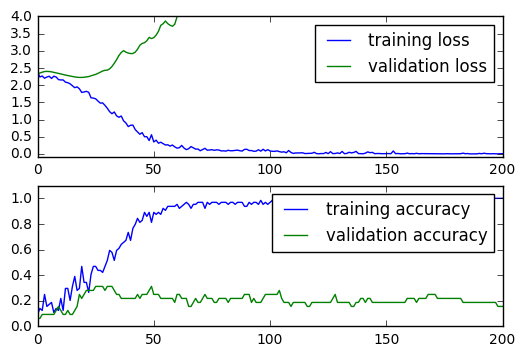

keep_prob		learning rate		init_std		valid accuracy
0.492059261208 		0.000645448270104 	0.0293291679773 	0.1875


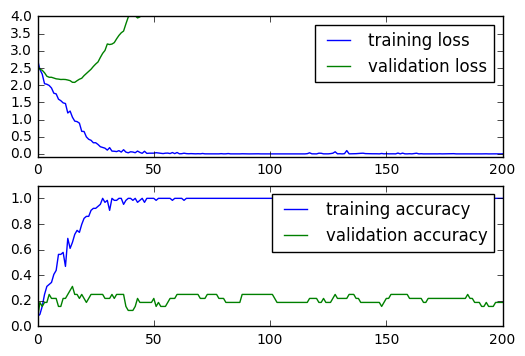

keep_prob		learning rate		init_std		valid accuracy
0.377034479848 		0.000958565933605 	0.0261982166976 	0.15625


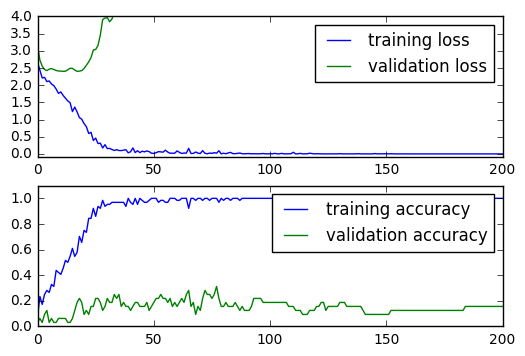

In [261]:
for key in experiment_data.keys():
    exp_data = experiment_data[key]
    if (exp_data['valid_acc'][-1]>.15) and (exp_data['train_acc'][-1]>.85):
        print "="*110
        print 'keep_prob\t\t', 'learning rate\t\t', 'init_std\t\t', 'valid accuracy'
        print key[0],'\t\t',key[1],'\t',key[2],'\t',exp_data['valid_acc'][-1]
        plot_data(exp_data)

### Experiments Results using GradientDescentOptimizer

keep_prob		learning rate		init_std		valid accuracy
0.643266171136 		0.000590863199104 	0.047781181769 	0.21875


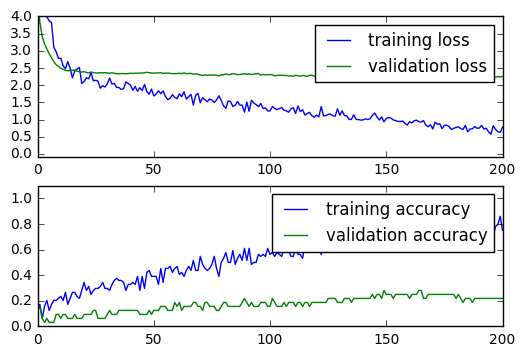

keep_prob		learning rate		init_std		valid accuracy
0.368223360246 		0.00434114880734 	0.0438743009846 	0.1875


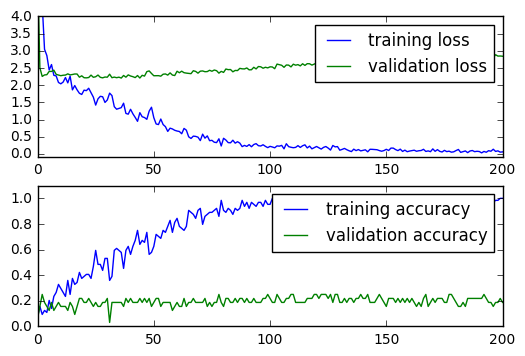

keep_prob		learning rate		init_std		valid accuracy
0.12018238235 		0.00457764137577 	0.0213012114215 	0.34375


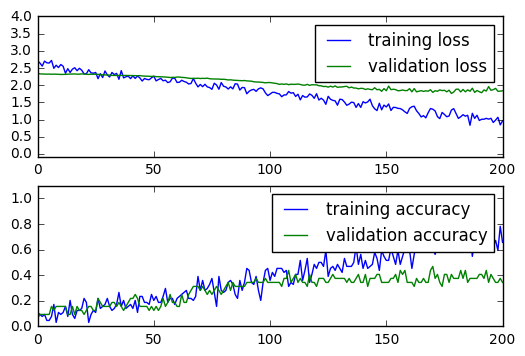

keep_prob		learning rate		init_std		valid accuracy
0.32980448851 		0.00388626412647 	0.0433601126718 	0.1875


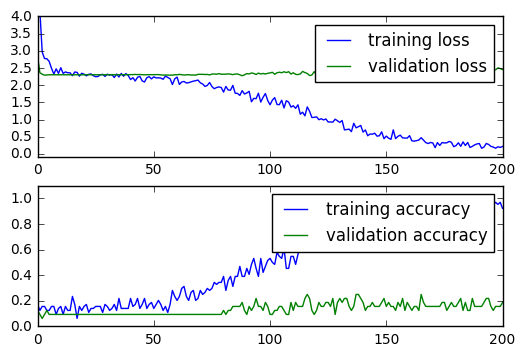

In [253]:
for key in experiment_data.keys():
    exp_data = experiment_data[key]
    if (exp_data['valid_acc'][-1]>.15) and (exp_data['train_acc'][-1]>.65):
        print "="*110
        print 'keep_prob\t\t', 'learning rate\t\t', 'init_std\t\t', 'valid accuracy'
        print key[0],'\t\t',key[1],'\t',key[2],'\t',exp_data['valid_acc'][-1]
        plot_data(exp_data)

***
### Summary
- Xavier Initializer (or ReLu Xavier Initializer) does not lead to a better result than truncated_normal_initializer with a std of about 0.01
- Initialize biases with constant 1.0 works better than 0.0
- For AdamOptimizer, the proper learning rate is at the scale of 0.0001 (picked 0.0003 in trail runs)
- For GradientDescentOptimizer, the proper learning rate is at a higher scale: ~0.005
- The loss function (softmax cross entropy) yeild through AdamOptimizer appears to be less nosiy than the one yeild through GradientDescentOptimizer
- Trail run parameters:
    - AdamOptimizer
    - Drop out keep prob: 0.5
    - Weights initialization: truncated_normal with stddev=0.015
    - Biases initialization : constant (1.0)
    - CONVNET architecture:
        * conv1: filter size 5x5, num of filters: 64, stride=1, padding=SAME + ReLu
        * pool1: filter size 2x2, max pooling, stride=2, padding=SAME
        * conv2: filter size 3x3, num of filters: 64, stride=1, padding=SAME + ReLu
        * pool2: filter size 2x2, max pooling, stride=2, padding=SAME
        * conv3: filter size 5x5, num of filters: 64, stride=1, padding=SAME + ReLu
        * pool3: filter size 2x2, max pooling, stride=1, padding=SAME
        * fc1  : 512 neurons
        * fc2  : 10 neurons
    
- Ran 2 trials:
    - Trial 1:
        - Total epoches ran: 1200, MiniBatch size: 512, Time cost per epoch: 72 secs
        - learning rate: 0.0003, decay rate: 0.8, decay steps: 300, staircase: True
        - Last Validation accuracy: ~60%/Best Validation accuracy: 72%; test accuracy: ~59%
    - Trial 2:
        - Total epoches ran: 1200, MiniBatch size: 512, Time cost per epoch: 72 secs
        - learning rate: 0.0003, decay rate: 0.8, decay steps: 150, staircase: True
        - Validation accuracy: ~63%/Best Validation accuracy: 71.63%; test accuracy: ~63%
    - Trial 3:
        - Total epoches ran: 2000, MiniBatch size: 512, Time cost per epoch: 72 secs
        - learning rate: 0.0001, decay rate: 0.9, decay steps: 100, staircase: True
        - Validation accuracy: ~63%/Best Validation accuracy: 64%; test accuracy: ~62%
    - Trial 4:
        - Total epoches ran: 1200, MiniBatch size: 512, Time cost per epoch: 72 secs
        - learning rate: 0.0003, decay rate: 0.9, decay steps: 77, staircase: False??
        - Validation accuracy: ~63%/Best Validation accuracy:~67.5%; test accuracy ~63%
    - Trial 5:
        - **Shuffled Augmented training dataset before feed into the ConvNet, which removed the spiky jumps**
        - Total epoches ran: 1200, MiniBatch size: 1024, Time cost per epoch: 77 secs
        - learning rate: 0.0004, decay rate: 0.9, decay steps: 100, staircase: False
        - Validation accuracy: ~73%/Best Validation accuracy:~74%; test accuracy ~73%
    - Trial 6:
        - Total epoches ran: 2500, MiniBatch size: 512, Time cost per epoch: 72 secs
        - learning rate: 0.0007, decay rate: 0.9, decay steps: 100, staircase: False
        - initializer: truncated_normal with stddev=0.023 * Xavier with ReLu initializer doesn't do as well
        - Validation accuracy: ~74%/Best Validation accuracy:~74%; test accuracy ~74%

### Analyze Trail Training Data
***
**Trail 1**

In [8]:
trail1_data = unpickle('training_data_stack2.1')

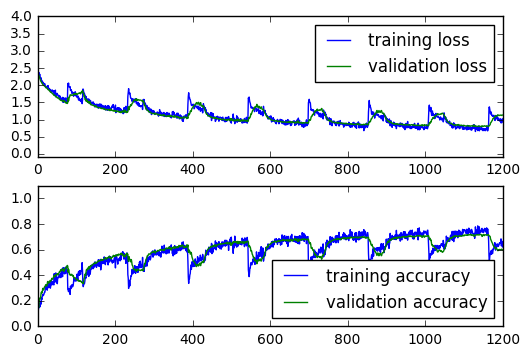

In [9]:
plot_data(trial1_data)

In [12]:
print "Final Validation Accuracy: %.2f \t Test Accuracy: %.2f" %(trial1_data['valid_acc'][-1], trial1_data['test_acc'])

Final Validation Accuracy: 0.60 	 Test Accuracy: 0.59


**The pattern appears to happen every 150-180 epoches, suspecting the proper decay steps for learning rate should be 150-180**
***
**Trial 2**

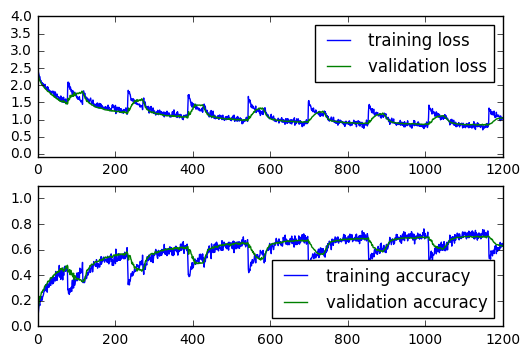

In [3]:
trial2_data = unpickle('training_data_stack2.2')
plot_data(trial2_data)

In [6]:
print "Final Validation Accuracy: %.2f \t Test Accuracy: %.2f" %(trial2_data['valid_acc'][-1], trial2_data['test_acc'])

Final Validation Accuracy: 0.63 	 Test Accuracy: 0.63


***
**Trial 3**

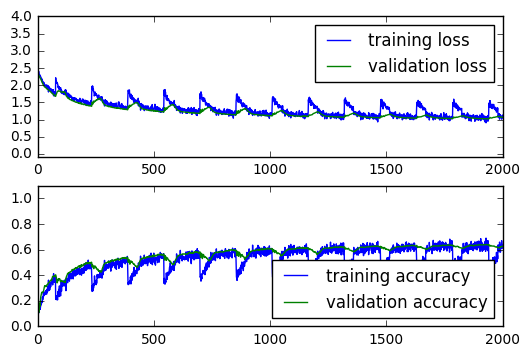

In [3]:
trial3_data = unpickle('training_data_stack2.3')
plot_data(trial3_data)

In [5]:
print "Final Validation Accuracy: %.2f \t Test Accuracy: %.2f" %(trial3_data['valid_acc'][-1], trial3_data['test_acc'])

Final Validation Accuracy: 0.63 	 Test Accuracy: 0.62


***
**Trial 4**

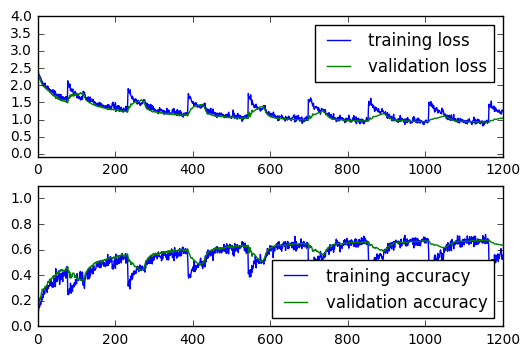

In [3]:
trial4_data = unpickle('training_data_stack2.4')
plot_data(trial4_data)

In [5]:
print "Final Validation Accuracy: %.2f \t Test Accuracy: %.2f" %(trial4_data['valid_acc'][-1], trial4_data['test_acc'])

Final Validation Accuracy: 0.63 	 Test Accuracy: 0.63


***
**Trial 5**

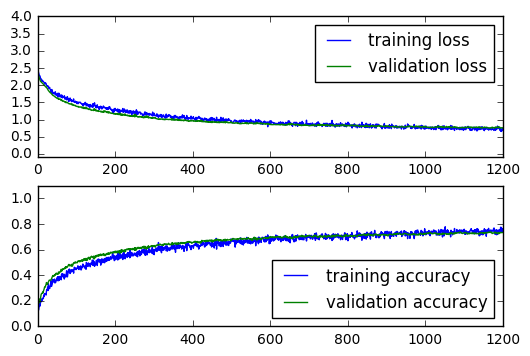

In [7]:
trial5_data = unpickle('training_data_stack2.5')
plot_data(trial5_data)

In [8]:
print "Final Validation Accuracy: %.2f \t Test Accuracy: %.2f" %(trial5_data['valid_acc'][-1], trial5_data['test_acc'])

Final Validation Accuracy: 0.73 	 Test Accuracy: 0.73


***
**Trial 6**

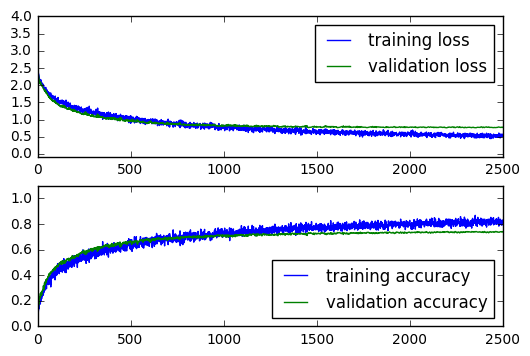

In [4]:
trial6_data = unpickle('training_data_stack2.6')
plot_data(trial6_data)

In [5]:
print "Final Validation Accuracy: %.2f \t Test Accuracy: %.2f" %(trial6_data['valid_acc'][-1], trial6_data['test_acc'])

Final Validation Accuracy: 0.74 	 Test Accuracy: 0.74
